# introduction

The purpose of this project is to identify vital sign correlates of emotional synchrony. In this experiment, experimental data is collected from pairs of experiment subjects (termed dyads) while they complete certain specified tasks meant to stimulate emotional connectedness. These tasks include closing their eyes, staring at each other, and talking to each other. As they perform these actions, vital sign data (EKG waveform, respiratory rate (measured through chest rise), and sweat electrodermal activity) are continuously recorded. Finally, at the conclusion of the experiment, each respondent fills out a survey detailing their perceived closeness to their partner, as well as a clinically validated depression screening inventory. 

The hypothesis of this project is that behaviors designed to increase emotional synchrony (such as staring at each other or talking to each other) are associated with an increased synchrony in some vital sign measure (how to measure synchrony is touched on below). A secondary hypothesis is that this synchrony measure correlates monotonically with i) a dyad's subjective rating of closeness toward each subject's counterpart; and ii) their depression inventory score.

### independent variables

Each experiment runs, in order, through the following trials:

- 1) eyes closed
- 2) staring
- 3) talking
- 4) eyes closed
- 5) staring
- 6) talking
- 7) eyes closed
- 8) staring
- 9) talking
- 10) eyes closed
- 11) staring

This results in a total of 11 experimental epochs. With these epochs, we can analyze the data the following ways:
- we can analyze the data separately by each epoch, creating 11 such comparisons between all our dyads. Each epoch is termed a "spike", after the light flash to indicate a new trial to participants. Thus, the second staring trial, for the example, is spike 5.
- we can average all spikes for the same type of behavior together (creating, for each dyad, an n = 4 statistic for eyes closed and staring, and an n = 3 statistic for talking). Data analyzed this way is variably referred to in my code as an "epoch", "type", "behavior", or "condition" but never as a spike (sorry!)
- we can look at the difference between the final spike and the initial spike for each behavior, giving us a measure of whether there was any numerical increase in synchrony over the experiment. 

Additionally, at the conclusion of the experiment, participants were asked to fill out the following:
- a numerical score denoting their perceived closeness to their experimental partner (higher number > more closeness)
- a Beck Depression Inventory, a clinical standard for depression screening (higher number > greater risk of depression)

### dependent variables

Throughout the experiment, the following data was continuously collected:
- EKG: single-lead EKG data
- respiratory rate: measured through chest rise with a mechanical sensor worn on the body
- sweat electrodermal activity (EDA): I don't have the greatest knowledge about this, but Googling EDA comes up with lots of information

### data analysis

How to define a synchrony function is not clear since many of our signals requiring some amount of filtering/pre-processing to be comparable in a meaningful way. In general there is a tradeoff between making an easy numerical comparison (for example, taking correlation coefficients between subjects as our synchrony function) and preserving dimensionality of data (more complex matrix methods that I never really got into). Additional information on synchrony measures and how the group thought about them can be found here: https://docs.google.com/document/d/1-fCIyDmNY2l-dK62SU2L9puMrJFlWzOtlFpH_6Vuaiw/edit?usp=sharing

In [ ]:
# Read files
import os
from os import walk
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import glob
import seaborn as sns; sns.set()
from numpy import inf
from scipy.signal import hilbert, butter, filtfilt, lfilter
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import seaborn as sns
import scipy.stats as stats
import re

%matplotlib inline

# load data

Assumes that your data (meaning individual .csv files containing all data for a given dyad) are stored in a folder /synchronized. Individual dyads should be named synchronized_xx.csv, where xx is a two-digit number corresponding to the dyad number. 

In [2]:
"""
load synchronized files

creates variables synchronized_files and dyad
synchronized_files is a list of DataFrames that will be the main data variable for all the code - each DataFrame corresponds to one dyad
dyads is a list of dyad numbers indexed to synchronized_files

"""

mypath = "synchronized/*.csv"

synchronized_files=[]
dyads = []

for entry in glob.glob(mypath):
    synchronized_files.append(pd.read_csv(entry, sep = ',', index_col = 0)) 
    filename = entry.split('/')[-1]
    for term in re.split('_|\.', filename):
        if term.isdigit():
            dyads.append(int(term))
    

# ekg/resp preprocessing 

### ekg signal

Our objective is to transform our raw cardiac and respiratory signals into a more usable format. For our cardiac data, this means extracting heart rate from a raw EKG signal. Specifically, from the given functions that document EKG signal as a function of time, we need to get functions that display rolling heart rate as a function of time. **Note that the sample rate is 100Hz.**

To do this, we must accomplish two tasks:
- digitize the raw EKG signal, such that each heart rate waveform (QRS complex) is "deconvolved" to a single peaks
- take a rolling reciprocal of the digitized signal over some arbitrary window to find the rate of peaks over each given window

The main considerations in completing this task are:
- there needs to be a way to exclude invalid data from analysis, because it is extremely noisy and using it to generate summary statistics for the dataset throws of all the numbers
- generally, invalid data is easy to inspect for visually

The general method is as follows: code below is documented for more in-depth explanations.
- First, manually populate a variable that stores where invalid data can be found for each subject. This requires manually going through the data, but generally invalid data isn't difficult to see.
- Digitize the raw signals, excluding invalid data from this new function (all invalid data is mapped to NaN instead, and does not show up on graphs). Digitization is based on a very simple script that involves z-score gating.
- The heart rate signal is calculated from the digital signal as outlined above.
- The rolling median is calculated to smooth out the function. 

### respiratory rate signal

The respiratory rate signal technically is a signal that is amenable to the same kind of analysis as the HR, as we care about the digital aspects of the signal (how many breaths the subject took) and not the actual number of centimeters the chest is rising every instant. However, the chest rise signal is substantially noisier than the EKG signal, especially during the talking portion. As such it is difficult to manually exclude invalid data, and the peak detection algorithms likely need to be more complex. 

For now, we simply clip outlers and scale the respiratory rate signal, but it probably needs more processing to give meaningful results.

In [ ]:
"""

adds a new column to synchronized files to specify whether regions of data are invalid: 1 if so, 0 is not, for use in future analysis. 

parameters: 
data- nx1 array of raw EKG data (though data is only passed to read its length, so any array of equal length will do)
outliers- list of lists of form [a,b], where a and b demarcate a single region in data such that data[a:b] is invalid.
this comes from visual inspection.

outputs:
is_invalid- nx1 array of elements where is_invalid[i] = 0 if data[i] is invalid, and 1 otherwise.

"""

def add_invalid(data, outliers):
    
    is_invalid = np.zeros(len(data))
    
    for i in outliers:
        [start, end] = i
        is_invalid[start:end] = 1

    return is_invalid

"""

finds peaks in a waveform based on each value's z-score from the baseline

params:
data: nx1 array of raw EKG data
outliers: list of lists of the form [a,b] that such data[a:b] is denoted as invalid. if the entire dataset is valid,
 should take an empty list
start: index to start peak detection 
end: index to finish peak detection
cutoff: z-score to cut off based on
convert_to_HR: boolean- see outputs for functionality
exclude_outlers: boolean- if 1, uses outliers argument to exclude analysis of invalid data. 1 by default.

outputs:
cutoffs_point: nx1 array where peaks are 1, non-peak values are zero, and invalid data is NaN. if convert_to_HR = 1, 
instead the value of cutoffs_point between consecutive peaks is the instantaneous heart rate in bpm calculated by 
inverting the time elapsed between those peaks.

"""

def PeakDetectionByZScore(data, outliers, start, end, cutoff, convert_to_HR, exclude_outliers = 1):
    
    # initialize empty arrays for outputs
    cutoffs = np.empty(len(data))
    cutoffs[:] = np.nan
    cutoffs_point = np.empty(len(data))
    cutoffs_point[:] = np.nan

    # convert invalid values in dataset to NaN
    for i in range(start,end):
        if not (exclude_outliers and outliers[i]):
            cutoffs[i] = data[i]
    
    # calculate array of z-scores while preserving NaNs
    nanzscore = lambda x: (x-np.nanmean(x))/np.nanstd(x,ddof=0)
    z_scores = nanzscore(cutoffs)

    # convert array to 1, 0, or nan depending on z-score cutoff
    for i in range(start,end):
        if not (np.isnan(cutoffs[i])):
            cutoffs[i] = (z_scores[i] > cutoff)

    #digitize peaks
    for i in range(start,end):
        if i == 0:
            cutoffs_point[i] = 0
        elif np.isnan(cutoffs[i]):
            cutoffs_point[i] = np.nan 
        else:
            cutoffs_point[i] = (cutoffs[i] > cutoffs[i-1])
    
    # convert area between peaks to instantaneous HR, but ignore NaNs
    if convert_to_HR:
        pre = 0
        post = 0
        for i in range(len(data)):
            if np.isnan(cutoffs_point[i]):
                pre = post
                post = i
                cutoffs_point[pre:post] = np.nan
            elif cutoffs_point[i] == 1:
                pre = post
                post = i
                cutoffs_point[pre:post] = 6000*np.reciprocal(float(post-pre))
    
    return cutoffs_point

In [4]:
# HR and RESP processing - Loop through files
files = len(synchronized_files)
    
    # each element in outliers_HR1 and outliers_HR2 is a single list corresponding to a single subject  
    # within those lists, a subject may have any number of two-element lists - each corresponding to a single interval over which 
    #      the HR data was visually judged to be invalid
    # as can be seen, many lists are empty; these subjects have entirely valid datasets
    
outliers_HR1 = [[],
                [[2000,2300],[6000,11000],[65000,75000],[110000,130000]],
                [],
                [],
                [],
                [],
                [],
                [],
                [],
                [[0,11000],[340000,360000]]]
outliers_HR2 = [[[72500,80000]],
                [],
                [],
                [[0,50000]],
                [],
                [[0,20000]],
                [],
                [],
                [],
                [[300000,-1]]]

for i in tqdm(range(files)):
    sf = synchronized_files[i]
    # Heart Rate
    cutoff = 2
    roll_range = 600
    
    #populate outliers field
    sf['outliers_HR1'] = add_invalid(sf, outliers_HR1[i])
    sf['outliers_HR2'] = add_invalid(sf, outliers_HR2[i])
    
    # clip edges of experiment
    startspike = np.where(sf['spike'] == 1)
    trial_start = startspike[0][0]
    endspike = np.where(sf['spike'] == 11)
    trial_end = endspike[0][-1]
    
        # Participant 1
    # Get instantaneous HR
    sf['insta_HR1'] = PeakDetectionByZScore(sf['raw_HR1'], sf['outliers_HR1'], trial_start, trial_end, cutoff, 1, 1)
    sf['peaks_HR1'] = PeakDetectionByZScore(sf['raw_HR1'], sf['outliers_HR1'], trial_start, trial_end, cutoff, 0, 1)
    # Smooth HR with Pandas rolling median function
    sf['smoothed_HR1'] = sf['insta_HR1'].rolling(roll_range).median()
    
        # Participant 2
    # for experiment 9, lower cutoffs works better
    if i == 9:
        cutoff = 1.5
    sf['insta_HR2'] = PeakDetectionByZScore(sf['raw_HR2'], sf['outliers_HR2'], trial_start, trial_end, cutoff, 1, 1)
    sf['peaks_HR2'] = PeakDetectionByZScore(sf['raw_HR2'], sf['outliers_HR2'], trial_start, trial_end, cutoff, 0, 1)
    sf['smoothed_HR2'] = sf['insta_HR2'].rolling(roll_range).median()

    # Respiration
        # Participant 1
        # Smooth RESP with Pandas rolling median function
    smoothed_RESP1 = sf['raw_RESP1'].rolling(roll_range).median()
    
        # Clip outliers
    resp1 = np.asarray(sf['raw_RESP1'][trial_start:trial_end])
    mean = np.mean(resp1, axis = 0)
    sd = np.std(resp1, axis=0)
    clipped_resp1 = np.clip(resp1, a_min = mean-2*sd, a_max = mean+2*sd)
        # Scale RESP
    scaled = np.zeros((len(sf), 1))
    scaler = MinMaxScaler()
    scaled[trial_start:trial_end] = scaler.fit_transform(np.reshape(clipped_resp1, (-1,1)))
    sf['SCALED_RESP1'] = scaled
   
        # Participant 2
        # Smooth RESP
    smoothed_RESP2 = sf['raw_RESP2'].rolling(roll_range).median()
        # Clip outliers
    resp2 = np.asarray(sf['raw_RESP2'][trial_start:trial_end])
    mean = np.mean(resp2, axis = 0)
    sd = np.std(resp2, axis=0)
    clipped_resp2 = np.clip(resp2, a_min = mean-2*sd, a_max = mean+2*sd)
        # Scale RESP
    scaled = np.zeros((len(sf), 1))    
    scaled[trial_start:trial_end] = scaler.fit_transform(np.reshape(clipped_resp2, (-1,1)))
    sf['SCALED_RESP2'] = scaled    
    

In [ ]:
##### plot using z-score-based algorithm

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
start = 0
end = 10000
i = 1 # file number

raw = synchronized_files[i]['raw_HR1']
processed = synchronized_files[i]['insta_HR1']
smoothed = synchronized_files[i]['smoothed_HR1']
peaks = synchronized_files[i]['peaks_HR1']

plt.plot(500*np.asarray(peaks[start:end]),color='r')
plt.plot(10*np.asarray(processed[start:end]))
plt.plot(10*np.asarray(smoothed[start:end]))
plt.plot(np.asarray(raw[start:end]))

# plt.plot(np.asarray(synchronized_files[i]['SCALED_RESP1'][start:end]))
print("median HR is", np.nanmedian(processed))

# EDA Preprocessing

EDA signal comes much cleaner than the HR and RR signals, and there's no obvious digital correlate (like a...sweat rate?) that requires us to transform the data substantially. Thus, we mainly do a bit of cleanup on the data - clip outliers and compress to a log scale.

According to the EDA manual, a common transform to apply is to extract the phasic signal (which seems to just mean highpass filter is) so that is implemented as well.

In [ ]:
# define filters
# Butterworth Filtering

def butter_bandpass(lowcut, highcut, fs, order=5):
    '''
    Filter design for filter coefficients
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    '''
    Filter data, returns filtered data
    '''
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter(column, lowcut, highcut, fs):
    '''
    Filter a column of data
    Input = column of data, lowcut frequency, highcut frequency, frequency of samples
    Return filtered data
    '''
    filt = butter_bandpass_filter(column, lowcut, highcut, fs, order=5)
    return filt

In [7]:
# Process EDA

files = len(synchronized_files)
for i in range(files):
    # Initiate processed EDA column
    synchronized_files[i]['processed_EDA1'] = np.nan
    synchronized_files[i]['processed_EDA2'] = np.nan
    EDA1 = synchronized_files[i]['raw_EDA1']
    EDA2 = synchronized_files[i]['raw_EDA2']
    
    # Smooth with rolling median
    roll_range = 400
    EDA1 = synchronized_files[i]['raw_EDA1'].rolling(roll_range).median()
    EDA2 = synchronized_files[i]['raw_EDA2'].rolling(roll_range).median()
    
    # Clip to Trial Ranges
    startspike = np.where(synchronized_files[i]['spike'] == 1)
    trial_start = startspike[0][0]
    endspike = np.where(synchronized_files[i]['spike'] == 11)
    trial_end = endspike[0][-1]

    clip1 = np.reshape(np.asarray(EDA1), (-1,1))[trial_start:trial_end]
    clip2 = np.reshape(np.asarray(EDA2), (-1,1))[trial_start:trial_end]
    
    # Normalize log(x+1)
    norm1 = np.log(np.asarray(clip1) + 1)
    norm2 = np.log(np.asarray(clip2) + 1)
    
    # Standardize Min Max
    scaler = MinMaxScaler()
    scaled1 = np.zeros([len(synchronized_files[i]),1])
    scaled2 = np.zeros([len(synchronized_files[i]),1])
    scaled1[trial_start:trial_end] = scaler.fit_transform(np.reshape(norm1,(-1,1)))
    scaled2[trial_start:trial_end] = scaler.fit_transform(np.reshape(norm2,(-1,1)))
    
    # Standardize Z-score
    zscore1 = np.zeros([len(synchronized_files[i]),1])
    zscore2 = np.zeros([len(synchronized_files[i]),1])
   
    zscore1[trial_start:trial_end] = (norm1-np.mean(norm1))/np.std(norm1)
    zscore2[trial_start:trial_end] = (norm2-np.mean(norm2))/np.std(norm2)
    
    synchronized_files[i]['scaled_EDA1'] = scaled1
    synchronized_files[i]['scaled_EDA2'] = scaled2
    synchronized_files[i]['zscore_EDA1'] = zscore1
    synchronized_files[i]['zscore_EDA2'] = zscore2

for sf in synchronized_files:
    sf['EDA1_phasic'] = filter(sf['scaled_EDA1'], .02, 49, 100)
    sf['EDA2_phasic'] = filter(sf['scaled_EDA2'], .02, 49, 100)


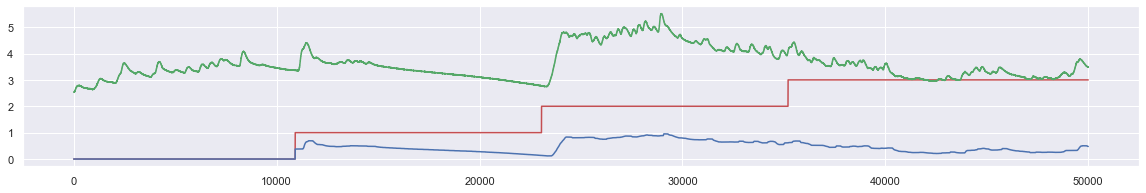

In [8]:
# plot raw EDA signal and scaled EDA signal

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
i = 3
start = 0
end = 50000

plt.plot(np.asarray(synchronized_files[i]['type'][start:end]),color='r')
plt.plot(np.asarray(synchronized_files[i]['raw_EDA1'][start:end]*0.01),color='g')
plt.plot(np.asarray(synchronized_files[i]['scaled_EDA1'][start:end]),color='b')
plt.plot(np.asarray(synchronized_files[i]['EDA1_phasic'][start:end]),color='y')

# analysis of individual responses

As sanity checks, we plot our HR, RR, and EDA data separately across all subjects in box-and-whisker plots (averaging each dyad's average value for each spike). We expect generally low variability as no dyad should be on average particularly different from any other (excepting the survey results)

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


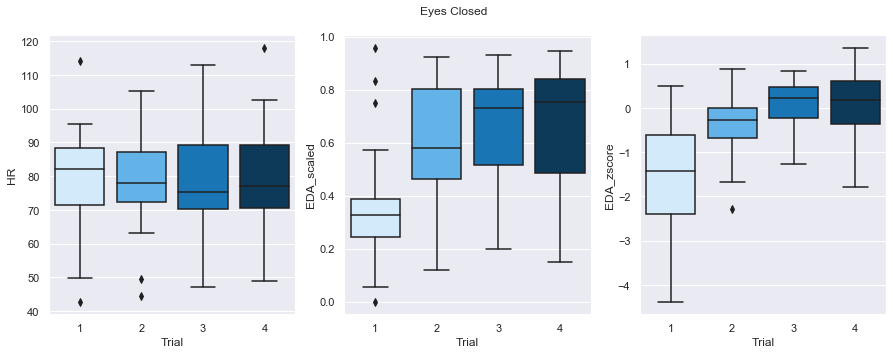

In [12]:
# Average response by Type
# Type 1 eyes closed - spikes 1, 4, 7, 10
# dim: experiments*2 x Trial x measurement type

type1_avg = pd.DataFrame(columns = ['Trial', 'Participant', 'HR', 'EDA_scaled', 'EDA_zscore'])
spikes = [1, 4, 7, 10]
trials = [1, 2, 3, 4]
participants = [0, 1]
i = 0 # starting index
for sf in synchronized_files:
    for s in range(len(spikes)):       
        for p in participants:
            type1_avg.loc[i, 'Trial'] = trials[s]
            type1_avg.loc[i, 'Participant'] = p
            type1_avg.loc[i, 'HR'] = np.nanmean(sf[sf.spike == spikes[s]]['smoothed_HR'+str(p+1)])
            type1_avg.loc[i, 'EDA_scaled'] = np.nanmean(sf[sf.spike == spikes[s]]['scaled_EDA'+str(p+1)])
            type1_avg.loc[i, 'EDA_zscore'] = np.nanmean(sf[sf.spike == spikes[s]]['zscore_EDA'+str(p+1)])
            i += 1

# cast dataframe values to float
type1_avg['HR'] = type1_avg['HR'].astype(float)
type1_avg['EDA_scaled'] = type1_avg['EDA_scaled'].astype(float)
type1_avg['EDA_zscore'] = type1_avg['EDA_zscore'].astype(float)

# Type 1 graph

colors = ["#ccebff", "#4db8ff","#007acc", "#003d66"]
sns.set_palette(sns.color_palette(colors))

fig, axs = plt.subplots(ncols=3, figsize=(15,5))
sns.boxplot(x='Trial', y='HR', data=type1_avg, ax=axs[0])
sns.boxplot(x='Trial', y='EDA_scaled', data=type1_avg, ax=axs[1])
sns.boxplot(x='Trial',y='EDA_zscore', data=type1_avg, ax=axs[2])
plt.subplots_adjust(top=0.9)
g=fig.suptitle('Eyes Closed') 

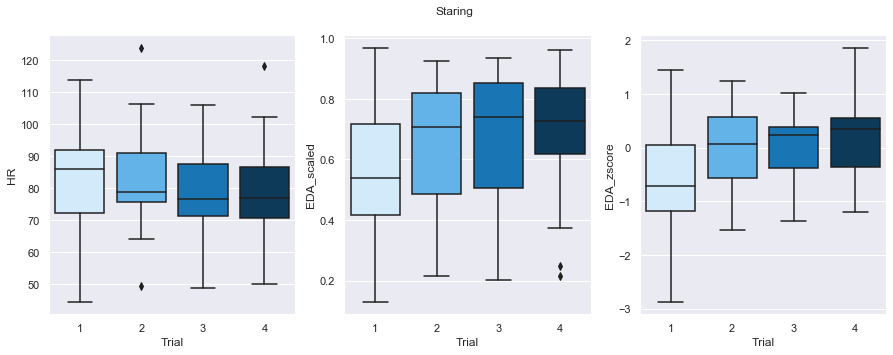

In [13]:
# Average response by Type
# Type 2 - spikes 2, 5, 8, 11
# dim: experiments*2 x Trial x measurement type

type2_avg = pd.DataFrame(columns = ['Trial', 'Participant', 'HR', 'EDA_scaled', 'EDA_zscore'])
spikes = [2, 5, 8, 11]
trials = [1, 2, 3, 4]
participants = [0, 1]
i = 0 # starting index
for sf in synchronized_files:
    for s in range(len(spikes)):       
        for p in participants:
            type2_avg.loc[i, 'Trial'] = trials[s]
            type2_avg.loc[i, 'Participant'] = p
            type2_avg.loc[i, 'HR'] = sf[sf.spike == spikes[s]]['smoothed_HR'+str(p+1)].mean()
            type2_avg.loc[i, 'EDA_scaled'] = sf[sf.spike == spikes[s]]['scaled_EDA'+str(p+1)].mean()
            type2_avg.loc[i, 'EDA_zscore'] = sf[sf.spike == spikes[s]]['zscore_EDA'+str(p+1)].mean()

            i += 1

type2_avg['HR'] = type2_avg['HR'].astype(float)
type2_avg['EDA_scaled'] = type2_avg['EDA_scaled'].astype(float)
type2_avg['EDA_zscore'] = type2_avg['EDA_zscore'].astype(float)

# Type 2 graph

fig, axs = plt.subplots(ncols=3, figsize=(15,5))
sns.boxplot(x='Trial', y='HR', data=type2_avg, ax=axs[0])
sns.boxplot(x='Trial', y='EDA_scaled', data=type2_avg, ax=axs[1])
sns.boxplot(x='Trial',y='EDA_zscore', data=type2_avg, ax=axs[2])

plt.subplots_adjust(top=0.9)
g=fig.suptitle('Staring') 

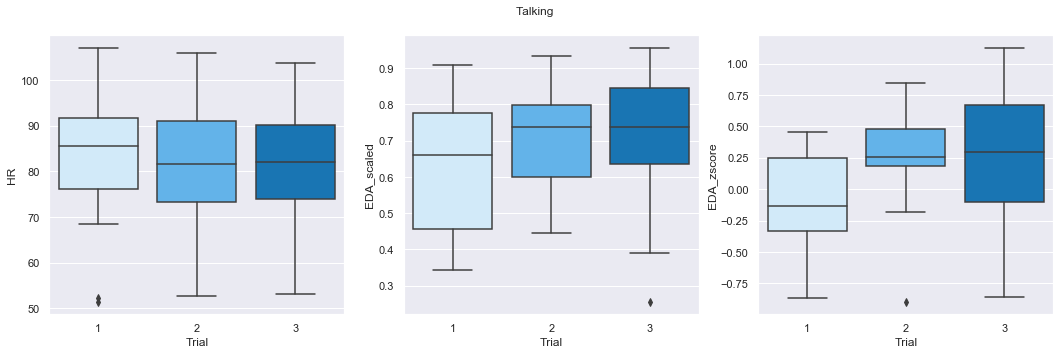

In [14]:
# Average response by Type
# Type 3 - spikes 3, 6, 9
# dim: experiments*2 x Trial x measurement type

type3_avg = pd.DataFrame(columns = ['Trial', 'Participant', 'HR', 'EDA_scaled', 'EDA_zscore'])
spikes = [3, 6, 9]
trials = [1, 2, 3]
participants = [0, 1]
i = 0 # starting index
for sf in synchronized_files:
    for s in range(len(spikes)):       
        for p in participants:
            type3_avg.loc[i, 'Trial'] = trials[s]
            type3_avg.loc[i, 'Participant'] = p
            type3_avg.loc[i, 'HR'] = sf[sf.spike == spikes[s]]['smoothed_HR'+str(p+1)].mean()
            type3_avg.loc[i, 'EDA_scaled'] = sf[sf.spike == spikes[s]]['scaled_EDA'+str(p+1)].mean()
            type3_avg.loc[i, 'EDA_zscore'] = sf[sf.spike == spikes[s]]['zscore_EDA'+str(p+1)].mean()

            i += 1

type3_avg['HR'] = type3_avg['HR'].astype(float)
type3_avg['EDA_scaled'] = type3_avg['EDA_scaled'].astype(float)
type3_avg['EDA_zscore'] = type3_avg['EDA_zscore'].astype(float)

fig, axs = plt.subplots(ncols=3, figsize=(18,5))
sns.boxplot(x='Trial', y='HR', data=type3_avg, ax=axs[0])
sns.boxplot(x='Trial', y='EDA_scaled', data=type3_avg, ax=axs[1])
sns.boxplot(x='Trial',y='EDA_zscore', data=type3_avg, ax=axs[2])

plt.subplots_adjust(top=0.9)
g=fig.suptitle('Talking')

overall, no apparent  difference in average HR, EDA scaled, or EDA z-score among the separate trials with eyes closed, open, or talking. 

In [ ]:
# plot raw EDA signal and scaled EDA signal
i = 0
start = 50000
end = 70000

plt.figure(figsize=(30,20))

plt.subplot(3,1,3)
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]),color='r')
plt.plot(np.asarray(synchronized_files[i]['raw_EDA1'][start:end]*0.01),color='g')
plt.plot(np.asarray(synchronized_files[i]['scaled_EDA1'][start:end]),color='b')
plt.title('EDA, raw/scaled',fontsize=30)

plt.subplot(3,1,2)
plt.plot(np.asarray(synchronized_files[i]['SCALED_RESP1'])[start:end], color='b')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]), color='r')
plt.title('respiratory data, scaled',fontsize=30)

plt.subplot(3,1,1)
plt.plot(np.asarray(synchronized_files[i]['peaks_HR1'][start:end])*100, color='y')
plt.plot(np.asarray(synchronized_files[i]['smoothed_HR1'][start:end]*10), color='g')
plt.plot(np.asarray(synchronized_files[i]['raw_HR1'][start:end])*.3, color='b')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]*100), color='r')
plt.title('HR, raw/peak detected',fontsize=30)

# statistics by epoch - define functions

Now we will look for statistics across trials of the same epoch (for example, all talking trials or all staring trials) and compare, generally, the final trial to the initial trial of a given behavior to assess whether there is an increase in any synchrony measure. 

In [16]:
# Average response by Type of trial (talking, staring, eyes closed)
# takes synchronized_files and a column descriptor denoting a certain class of data, say HR or respiratory rate,
# returns 3 numbers returning the average value of that data class, separated by trial type:
# use this function to calculate, say, average pearson correlations by epoch, for box/whisker plotting
# [data[eyes closed], data[staring], data[talking]]

def averagebytype(synchronized_files, column, quantity):
    type1_avg = pd.DataFrame(columns = ['Trial', 'EyesClosed'])
    type2_avg = pd.DataFrame(columns = ['Trial', 'Staring'])
    type3_avg = pd.DataFrame(columns = ['Trial', 'Talking'])

    # Type1
    spikes = [1, 4, 7, 10]
    trials = [1, 2, 3, 4]
    i = 0 # starting index
    for sf in synchronized_files:
        for s in range(len(spikes)):       
            type1_avg.loc[i, 'Trial'] = trials[s]
            type1_avg.loc[i, 'EyesClosed'] = np.nanmean(sf[sf.spike == spikes[s]][column])
            i += 1
    # Type2
    spikes = [2, 5, 8, 11]
    trials = [1, 2, 3, 4]
    i = 0 # starting index
    for sf in synchronized_files:
        for s in range(len(spikes)):       
            type2_avg.loc[i, 'Trial'] = trials[s]
            type2_avg.loc[i, 'Staring'] = np.nanmean(sf[sf.spike == spikes[s]][column])
            i += 1

    # Type3
    spikes = [3, 6, 9]
    trials = [1, 2, 3]
    i = 0 # starting index
    for sf in synchronized_files:
        for s in range(len(spikes)):       
            type3_avg.loc[i, 'Trial'] = trials[s]
            type3_avg.loc[i, 'Talking'] = np.nanmean(sf[sf.spike == spikes[s]][column])
            i += 1            

    type1_avg['EyesClosed'] = type1_avg['EyesClosed'].astype(float)
    type2_avg['Staring'] = type2_avg['Staring'].astype(float)
    type3_avg['Talking'] = type3_avg['Talking'].astype(float)

    fig, axs = plt.subplots(ncols=3, figsize=(18,4))
    sns.boxplot(x='Trial', y='EyesClosed', data=type1_avg, ax=axs[0])
    sns.boxplot(x='Trial', y='Staring', data=type2_avg, ax=axs[1])
    sns.boxplot(x='Trial', y='Talking', data=type3_avg, ax=axs[2])

    plt.subplots_adjust(top=0.9)
    g=fig.suptitle(quantity)
    
    return type1_avg, type2_avg, type3_avg

# stacks data into summary statistics averaged by epoch, useful for plotting aggregate end-start values 
# of a given statistic 

def getbyepoch(synchronized_files, quantity, trial, experiment_type, r_windowsize=500):
  pearson_synchrony = []
  spike = (trial-1)*3 + experiment_type    
  for sf in synchronized_files:
    values = np.asarray(sf[sf.spike == spike][quantity])
    values[values == -inf] = np.nan
    values[values == inf] = np.nan
    pearson_synchrony.append(np.nanmean(values))
  return pearson_synchrony

# hr - pearson correlation

### summary stats

Our first analysis uses the pearson correlation. Because we have a rolling heart rate graph for each experimental subject, we can take a *rolling Pearson correlation* of an arbitrary window and assess the evolution of this correlation over time and with each different behavior. 

One pitfall here is that the rolling heart rate graphs are not entirely analog; they have sharp step-offs due to the underlying signal being digital. This is equivalent to saying that the sample rate is too high for the signal, creating edge effects (kind of like reverse aliasing). To mitigate this, we first downsample to a new sample rate of 2 Hz. 

In [17]:
"""

simple downsampling function

params:
synchronized_files - data file
column - string specifying the column in the dyad DataFrame to operate on (for heart rate, this would be 'smoothed_HR1' or 'smoothed_HR2')
downsample_rate - the factor by which to downsample 

outputs:
downsampled_HRs - a new list of where the ith element is an array containing a downsampled copy of synchronized_files[i][column]

"""

def downsample(synchronized_files, column, downsample_rate):

    downsampled_HRs = []
    
    for i in range(len(synchronized_files)):
        sf = synchronized_files[i]
        downsampled_HRs.append(sf[column][::downsample_rate])
    return downsampled_HRs
        

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5, 0, 'time')

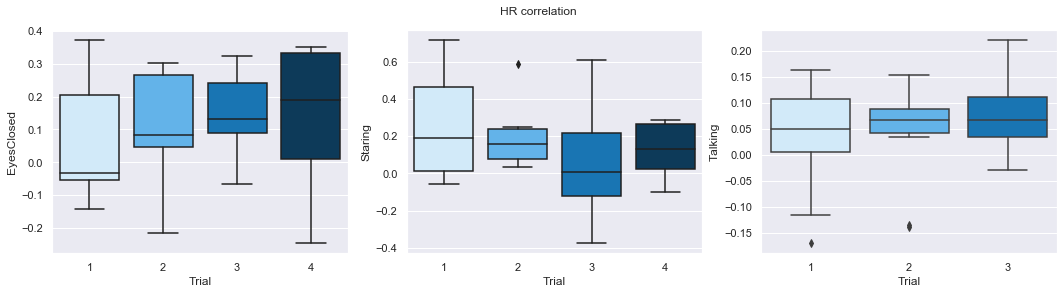

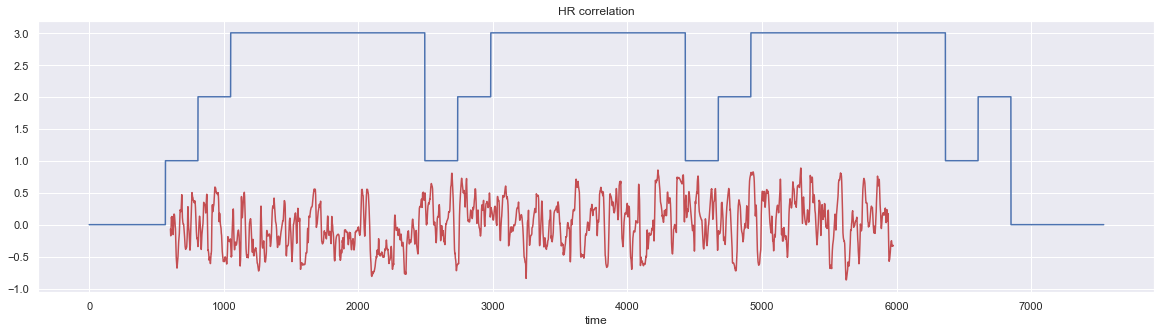

In [18]:
# downsample all HR signals to remove edge artifacts 

subsample_rate = 50

dshr1 = downsample(synchronized_files, 'smoothed_HR1', subsample_rate)
dshr2 = downsample(synchronized_files, 'smoothed_HR2', subsample_rate)
spike = downsample(synchronized_files, 'spike', subsample_rate)
types = downsample(synchronized_files, 'type', subsample_rate)

window = 50

# calculate rolling correlation between users as a function of experimental epoch
dshrcorr = []
for i in range(len(dshr1)):
    dshrcorr.append(np.asarray(dshr1[i].rolling(window=window, center=True).corr(dshr2[i])))
dshrcorr = np.asarray(dshrcorr)

dshrcorrs = []

for i in range(len(dshr1)):
    expt = pd.DataFrame()
    expt['smoothed_HR1'] = dshr1[i]
    expt['smoothed_HR2'] = dshr2[i]
    expt['spike'] = spike[i]
    expt['type'] = types[i]
    expt['HRcorrs'] = dshrcorr[i]
    dshrcorrs.append(expt)


a1, a2, a3 = averagebytype(dshrcorrs, 'HRcorrs', 'HR correlation')

#plot HR correlation with time

i = 9
start = 0
end = -1

plt.figure(figsize=(20,5))
plt.plot(np.asarray(dshrcorr[i])[start:end],color='r')
plt.plot(np.asarray(types[i][start:end]),color='b')
plt.title('HR correlation')
plt.xlabel('time')

### by epoch

Then, we stratify analyses by behavior, taking the difference of the final and initial trials for each behavior. Here we are asking: within a given behavior, does our measure of synchrony evolve over the course of the experiment?

In [19]:
# iterate through all trials and store average correlation data in one list for easy access

average_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): #dont run the last iteration
            average_corrs.append(getbyepoch(dshrcorrs, 'HRcorrs', trial+1, epoch+1))

            # initialize matrix storing average epoch pearson correlations for a single manipulation

HR_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
HR_closed['start'] = average_corrs[0]
HR_closed['second'] = average_corrs[3]
HR_closed['third'] = average_corrs[6]
HR_closed['end'] = average_corrs[9] 
HR_closed['delta'] = HR_closed['end'] - HR_closed['start']

HR_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
HR_staring['start'] = average_corrs[1]
HR_staring['second'] = average_corrs[4]
HR_staring['third'] = average_corrs[7]
HR_staring['end'] = average_corrs[10] 
HR_staring['delta'] = HR_staring['end'] - HR_staring['start']

HR_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
HR_talking['start'] = average_corrs[2]
HR_talking['second'] = average_corrs[5]
HR_talking['end'] = average_corrs[8] 
HR_talking['delta'] = HR_talking['end'] - HR_talking['start']

# t-test between conditions

trial1, epoch1 = [1,3] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [3,3] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_corrs[spike1],average_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


Ttest_relResult(statistic=-1.5636530537504518, pvalue=0.1523367862125601)

no significant results here

# hr variability - rmssd pearson correlation

There are more ways to think about synchrony than just the pearson correlation of heart rate. For example, if subjects had different resting heart rates, they may become more synchronzed, but never approach the same value. In fact, if subjects' heart rates are at all out of phase, the pearson correlation will naturally drift. 

Another way to quantify synchrony is to measure correlation between HR variability, which itself is a statistic with multiple different ways to measure. A common one used in the literature is the RMSSD, which is the root-mean-square of successive differences. So within a given time window, all the differences between successive measurements are taken, and this is root-mean-squared. Thus a stable HR will have an RMSSD of 0. Note that this RMSSD is sensitive to short-term variability at the expense of long-term variability: if there is extremely stable beat-to-beat variability, the RMSSD will be off the charts, but a slow yet ultimately substantial increase or decrease in heart rate will not produce a high RMSSD.

also FWIW: this code is EXTREMELY slow. It's been a while, I'm *sure* it can be sped up.

### summary stats

In [20]:
# create function to get rolling RMSSDs of a HR graph

def rolling_rmssd(synchronized_files, window):
    for i in range(len(synchronized_files)):
        sf = synchronized_files[i]
        rmssds = np.zeros(len(sf))

        peaks = sf['peaks_HR1']
        for j1 in range(len(peaks)):
            if j1 >= window:
                x = peaks[j1-window:j1]
                peakslist = x[x == 1].index
                diffs = np.diff(peakslist)
                rmssds[j1] = np.sqrt(np.nanmean(diffs**2))
        sf['rmssd_HR1'] = rmssds
  
        peaks = sf['peaks_HR2']
        for j2 in range(len(peaks)):
            if j2 >= window:
                x = peaks[j2-window:j2]
                peakslist = x[x == 1].index
                diffs = np.diff(peakslist)
                rmssds[j2] = np.sqrt(np.nanmean(diffs**2))
        sf['rmssd_HR2'] = rmssds
                          
rolling_rmssd(synchronized_files, 2000)                

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


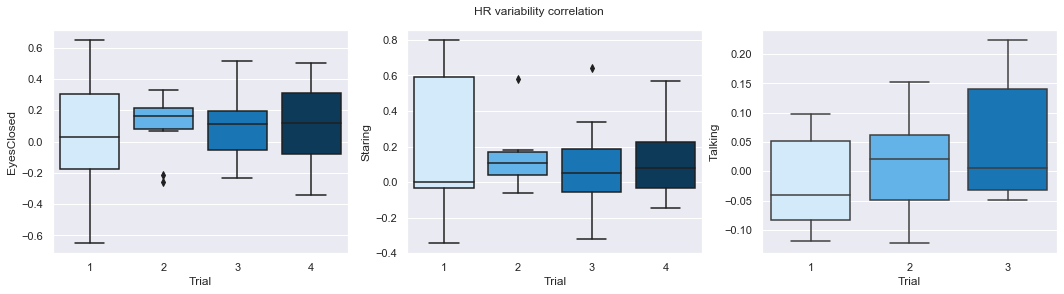

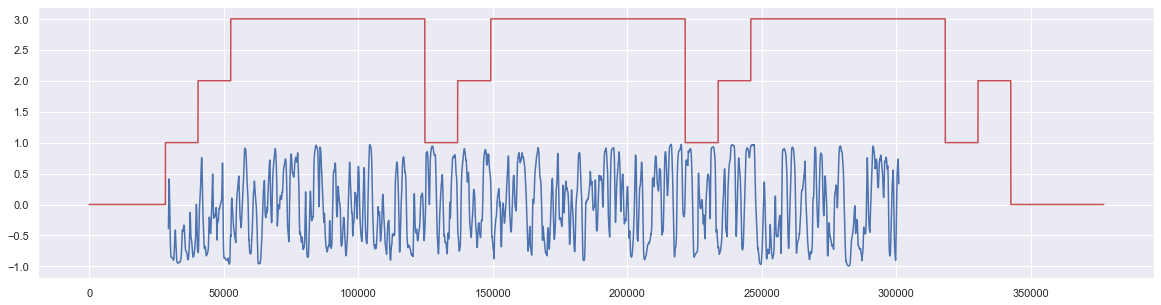

In [21]:
# get correlations of RMSSD

window = 2000 #window to calculate rolling correlations
for sf in synchronized_files:
    sf['rmssd_corr'] = sf['rmssd_HR1'].rolling(window=window, center=True).corr(sf['rmssd_HR2'])

a1,a2,a3 = averagebytype(synchronized_files, 'rmssd_corr', 'HR variability correlation')

# graph rolling RMSSD correlation

i = 9
start = 0
end = -1

plt.figure(figsize=(20,5))
plt.plot(np.asarray(synchronized_files[i]['rmssd_corr'][start:end]),color='b')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]),color='r')

### by epoch

In [22]:
# calculate pearson corr for all trials 
average_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): # dont run the last permutation as it doesn't exist
            average_corrs.append(getbyepoch(synchronized_files, 'rmssd_corr', trial+1, epoch+1))

# initialize matrix storing average epoch pearson correlations for a single manipulation
rmssd_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
rmssd_closed['start'] = average_corrs[0]
rmssd_closed['second'] = average_corrs[3]
rmssd_closed['third'] = average_corrs[6]
rmssd_closed['end'] = average_corrs[9] 
rmssd_closed['delta'] = rmssd_closed['end'] - rmssd_closed['start']

rmssd_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
rmssd_staring['start'] = average_corrs[1]
rmssd_staring['second'] = average_corrs[4]
rmssd_staring['third'] = average_corrs[7]
rmssd_staring['end'] = average_corrs[10] 
rmssd_staring['delta'] = rmssd_staring['end'] - rmssd_staring['start']

rmssd_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
rmssd_talking['start'] = average_corrs[2]
rmssd_talking['second'] = average_corrs[5]
rmssd_talking['end'] = average_corrs[8] 
rmssd_talking['delta'] = rmssd_talking['end'] - rmssd_talking['start']

rmssd_closed, rmssd_staring, rmssd_talking

# t-test between conditions

trial1, epoch1 = [1,3] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [3,3] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_corrs[spike1], average_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


Ttest_relResult(statistic=-2.455903826332677, pvalue=0.036402446383744756)

increased synchrony (end - start positive) significant result for talking only

# rr - pearson correlation

### summary stats

In [ ]:
#populate synchronized_files with pearson correlation data between individuals' respiratory data

window = 2000 #window to calculate rolling correlations
for sf in synchronized_files:
    sf['pearson_resp'] = sf['SCALED_RESP1'].rolling(window=window, center=True).corr(sf['SCALED_RESP2'])

pearson_type1, pearson_type2, pearson_type3 = averagebytype(synchronized_files, 'pearson_resp', 'respiratory pearson correlation')

# visualize evolution of respiratory correlation with experiment

i = 9
start = 0
end = -1

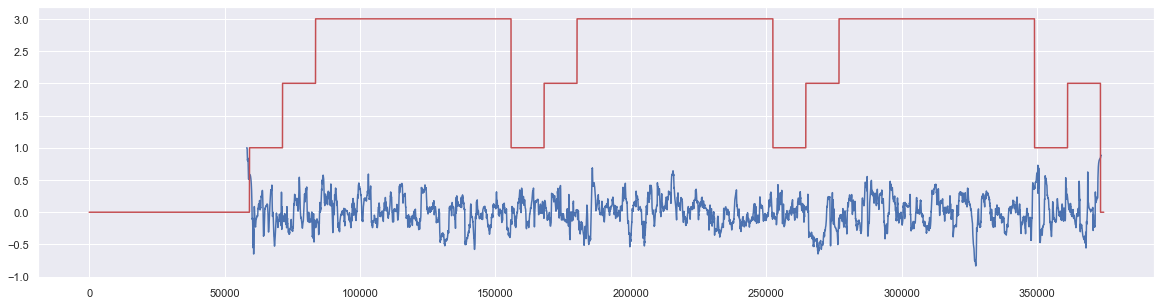

In [24]:
#plot resp correlation

i = 0
start = 0
end = -1

plt.figure(figsize=(20,5))
plt.plot(np.asarray(synchronized_files[i]['pearson_resp'][start:end]), color='b')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]), color='r')

### by epoch

In [25]:
# calculate pearson corr for all trials 
average_resp_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): # dont run the last permutation as it doesn't exist
            average_resp_corrs.append(getbyepoch(synchronized_files, 'pearson_resp', trial+1, epoch+1))

# initialize matrix storing average epoch pearson correlations for a single manipulation
resp_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
resp_closed['start'] = average_resp_corrs[0]
resp_closed['second'] = average_resp_corrs[3]
resp_closed['third'] = average_resp_corrs[6]
resp_closed['end'] = average_resp_corrs[9] 
resp_closed['delta'] = resp_closed['end'] - resp_closed['start']

resp_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
resp_staring['start'] = average_resp_corrs[1]
resp_staring['second'] = average_resp_corrs[4]
resp_staring['third'] = average_resp_corrs[7]
resp_staring['end'] = average_resp_corrs[10] 
resp_staring['delta'] = resp_staring['end'] - resp_staring['start']

resp_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
resp_talking['start'] = average_resp_corrs[2]
resp_talking['second'] = average_resp_corrs[5]
resp_talking['end'] = average_resp_corrs[8] 
resp_talking['delta'] = resp_talking['end'] - resp_talking['start']

resp_closed, resp_staring, resp_talking

# t-test between conditions

trial1, epoch1 = [1,1] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [4,1] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_resp_corrs[spike1], average_resp_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

Ttest_relResult(statistic=-2.7292221105494217, pvalue=0.023254127503822174)

significantly increased synchrony (end - start is positive) for closed, staring conditions (not talking)

# rr - instantaneous phase synchrony

I don't have a great grasp of instantaneous phase synchrony but it's a synchrony measure between -1 and 1, where the extremes indicate signals that are perfectly in phase or out of phase. This could potentially be something we could implement for HR and EDA as well, as they're both technically phasic signals (sort of for HR). 

### summary statistics

In [26]:
#butterworth filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = 0.1 #0.01
highcut = 2
fs = 100
order = 1

# populates sf['phase_synchrony'] with phase synchrony measurement between RESP1 and RESP2
for sf in synchronized_files:
    resp1 = sf['SCALED_RESP1']
    resp2 = sf['SCALED_RESP2']

    y1 = butter_bandpass_filter(resp1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(resp2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    sf['phase_synchrony'] = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


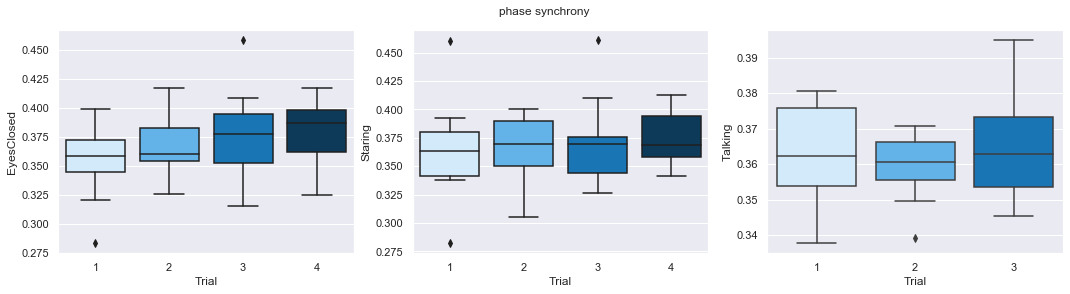

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


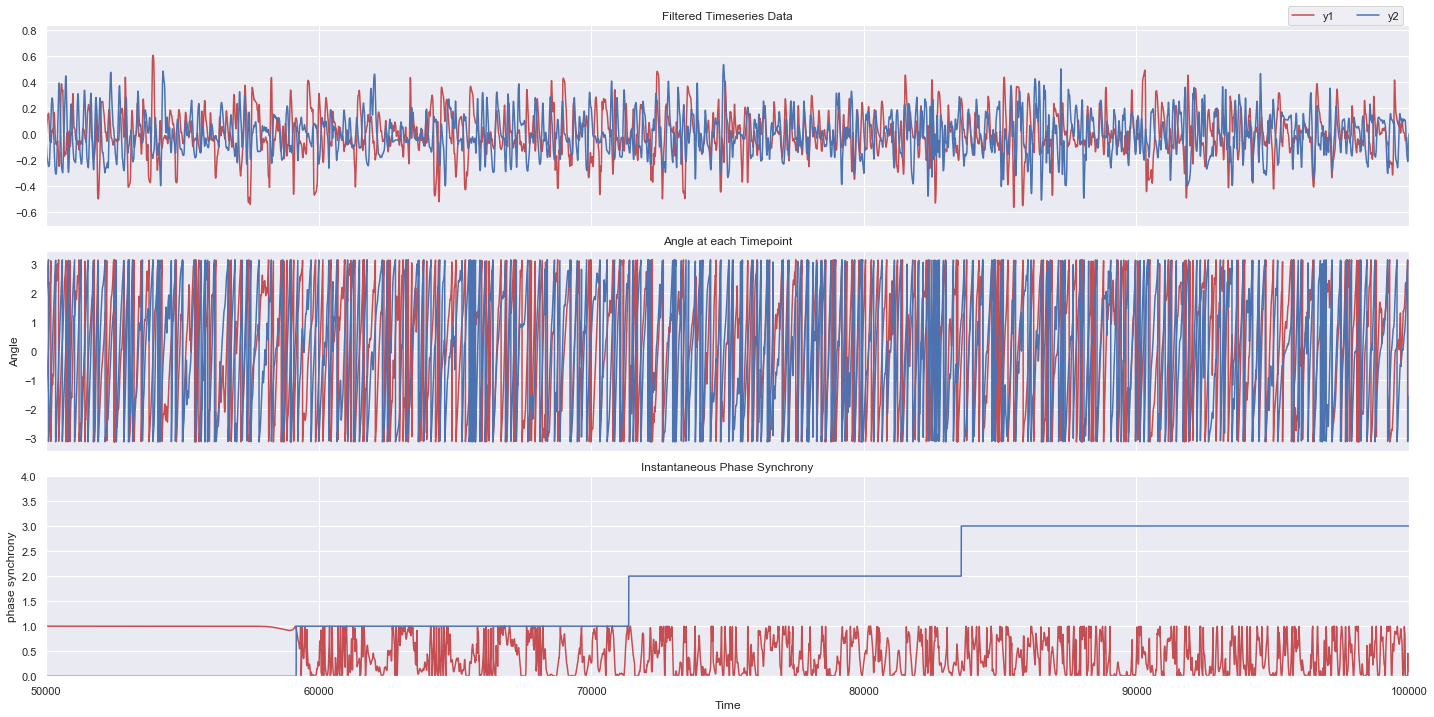

In [46]:
# plot average phase synchrony by trial type and trial #

ps_type1, ps_type2, ps_type3 = averagebytype(synchronized_files, 'phase_synchrony', 'phase synchrony')

# plot phase synchrony measures

start = 50000
end = 100000
i = 0

f,ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(title='Filtered Timeseries Data',xlim=[start,end])
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',xlim=[start,end],title='Angle at each Timepoint')
ax[2].plot(synchronized_files[i]['phase_synchrony'],color='r')
ax[2].plot(synchronized_files[i]['type'],color='b')
ax[2].set(ylim=[0,4],xlim=[start,end],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='phase synchrony')
plt.tight_layout()
plt.show()

### by epoch

In [28]:
# calculate pearson corr for all trials 
average_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): # dont run the last permutation as it doesn't exist
            average_corrs.append(getbyepoch(synchronized_files, 'phase_synchrony', trial+1, epoch+1))

# initialize matrix storing average epoch pearson correlations for a single manipulation
ps_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
ps_closed['start'] = average_corrs[0]
ps_closed['second'] = average_corrs[3]
ps_closed['third'] = average_corrs[6]
ps_closed['end'] = average_corrs[9] 
ps_closed['delta'] = ps_closed['end'] - ps_closed['start']

ps_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
ps_staring['start'] = average_corrs[1]
ps_staring['second'] = average_corrs[4]
ps_staring['third'] = average_corrs[7]
ps_staring['end'] = average_corrs[10] 
ps_staring['delta'] = ps_staring['end'] - ps_staring['start']

ps_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
ps_talking['start'] = average_corrs[2]
ps_talking['second'] = average_corrs[5]
ps_talking['end'] = average_corrs[8] 
ps_talking['delta'] = ps_talking['end'] - ps_talking['start']

ps_closed, ps_staring, ps_talking

# t-test between conditions

trial1, epoch1 = [1,3] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [3,3] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_corrs[spike1], average_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

Ttest_relResult(statistic=-0.6105414158010188, pvalue=0.5566047786379347)

no significant results here

# eda - pearson correlation

### summary statistics

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


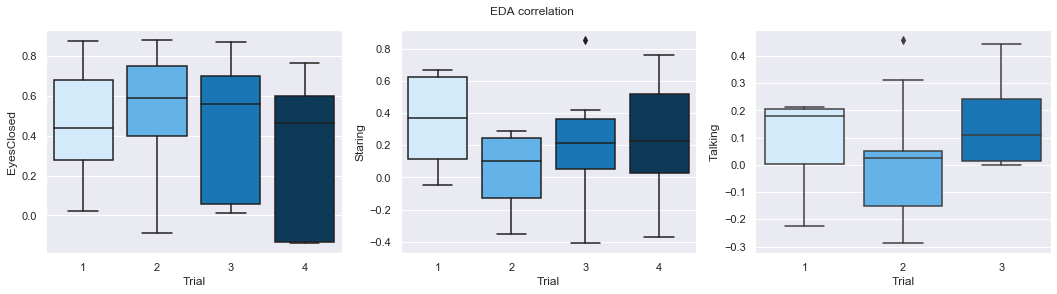

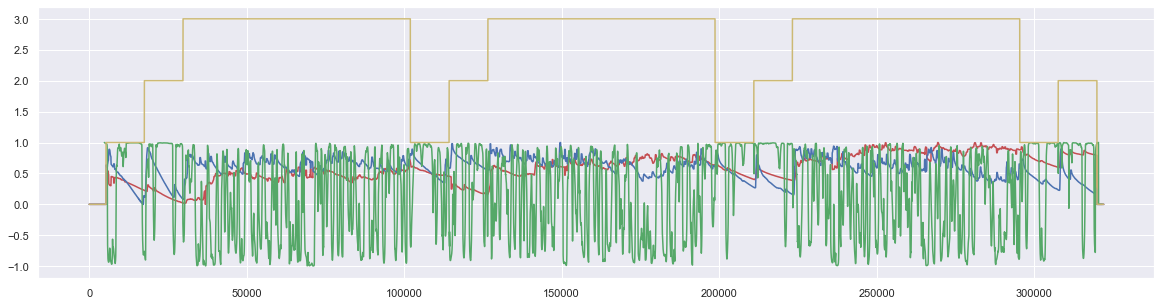

In [29]:
# calculate pearson correlation between individuals using scaled EDA data

window = 1000

for sf in synchronized_files:
    sf['pearson_EDA'] = sf['scaled_EDA1'].rolling(window=window, center=True).corr(sf['scaled_EDA2'])
    
# accrue average EDA values by trial type

EDAps_type1, EDAps_type2, EDAps_type3 = averagebytype(synchronized_files, 'pearson_EDA', 'EDA correlation')

# plot EDA responses and rolling pearson correlation 

start = 0
end = -1
i = 1

plt.figure(figsize=(20,5))
plt.plot(np.asarray(synchronized_files[i]['scaled_EDA1'][start:end]),color='r')
plt.plot(np.asarray(synchronized_files[i]['scaled_EDA2'][start:end]),color='b')
plt.plot(np.asarray(synchronized_files[i]['pearson_EDA'][start:end]),color='g')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]),color='y')

### by epoch

In [30]:
# iterate through all trials and store average correlation data in one list for easy access

average_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): #dont run the last iteration
            average_corrs.append(getbyepoch(synchronized_files, 'pearson_EDA', trial+1, epoch+1))

# initialize matrix storing average epoch pearson correlations for a single manipulation

EDA_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
EDA_closed['start'] = average_corrs[0]
EDA_closed['second'] = average_corrs[3]
EDA_closed['third'] = average_corrs[6]
EDA_closed['end'] = average_corrs[9] 
EDA_closed['delta'] = EDA_closed['end'] - EDA_closed['start']

EDA_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
EDA_staring['start'] = average_corrs[1]
EDA_staring['second'] = average_corrs[4]
EDA_staring['third'] = average_corrs[7]
EDA_staring['end'] = average_corrs[10] 
EDA_staring['delta'] = EDA_staring['end'] - EDA_staring['start']

EDA_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
EDA_talking['start'] = average_corrs[2]
EDA_talking['second'] = average_corrs[5]
EDA_talking['end'] = average_corrs[8] 
EDA_talking['delta'] = EDA_talking['end'] - EDA_talking['start']

# t-test between individual spikes

trial1, epoch1 = [1,3] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [3,3] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_corrs[spike1], average_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


Ttest_relResult(statistic=-1.143450281460427, pvalue=0.2823539858198327)

no significant findings here

# eda phasic signal - pearson correlation

### summary stats

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


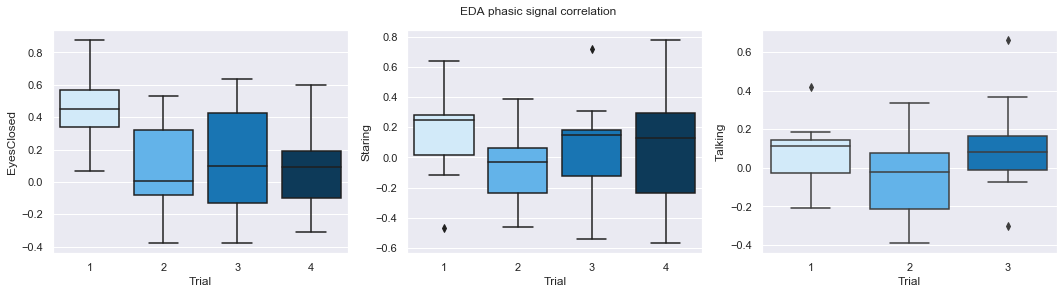

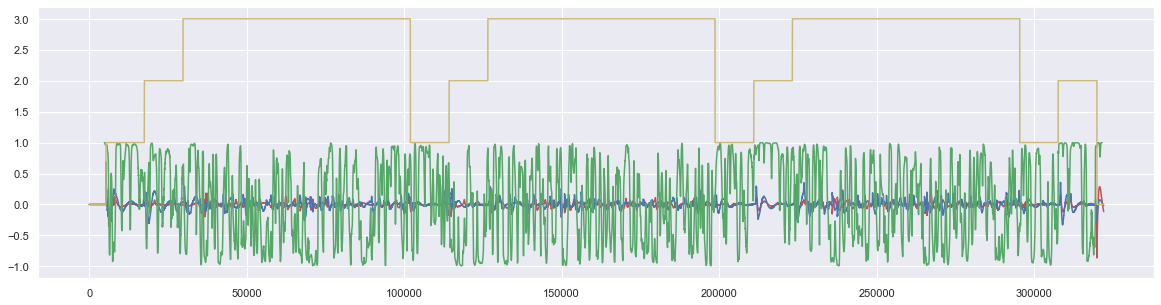

In [33]:
# calculate pearson correlation between individuals using scaled EDA data

window = 1000

for sf in synchronized_files:
    sf['pearson_EDA_phasic'] = sf['EDA1_phasic'].rolling(window=window, center=True).corr(sf['EDA2_phasic'])
    
# accrue average EDA values by trial type

EDAps_type1, EDAps_type2, EDAps_type3 = averagebytype(synchronized_files, 'pearson_EDA_phasic', 'EDA phasic signal correlation')

# plot EDA responses and rolling pearson correlation 

start = 0
end = -1
i = 1

plt.figure(figsize=(20,5))
plt.plot(np.asarray(synchronized_files[i]['EDA1_phasic'][start:end]),color='r')
plt.plot(np.asarray(synchronized_files[i]['EDA2_phasic'][start:end]),color='b')
plt.plot(np.asarray(synchronized_files[i]['pearson_EDA_phasic'][start:end]),color='g')
plt.plot(np.asarray(synchronized_files[i]['type'][start:end]),color='y')

### by epoch

In [34]:
# calculate pearson corr for all trials 
average_corrs = []

for trial in range(4): # number of trials
    for epoch in range(3): # number of experiment types- 1,2,3 > eye closed, staring, talking
        if not (trial == 3 and epoch == 2): # dont run the last permutation as it doesn't exist
            average_corrs.append(getbyepoch(synchronized_files, 'pearson_EDA_phasic', trial+1, epoch+1))

# initialize matrix storing average epoch pearson correlations for a single manipulation
ps_closed = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
ps_closed['start'] = average_corrs[0]
ps_closed['second'] = average_corrs[3]
ps_closed['third'] = average_corrs[6]
ps_closed['end'] = average_corrs[9] 
ps_closed['delta'] = ps_closed['end'] - ps_closed['start']

ps_staring = pd.DataFrame(columns = ['start', 'second', 'third', 'end'])
ps_staring['start'] = average_corrs[1]
ps_staring['second'] = average_corrs[4]
ps_staring['third'] = average_corrs[7]
ps_staring['end'] = average_corrs[10] 
ps_staring['delta'] = ps_staring['end'] - ps_staring['start']

ps_talking = pd.DataFrame(columns = ['start', 'second', 'end'])
ps_talking['start'] = average_corrs[2]
ps_talking['second'] = average_corrs[5]
ps_talking['end'] = average_corrs[8] 
ps_talking['delta'] = ps_talking['end'] - ps_talking['start']

ps_closed, ps_staring, ps_talking

# t-test between conditions

trial1, epoch1 = [1,1] #e.g. 1,1 > first trial, eyes closed
trial2, epoch2 = [4,1] #e.g. 4,1 > last trial, eyes closed (first experiment type)

spike1 = (trial1-1)*3 + epoch1 - 1
spike2 = (trial2-1)*3 + epoch2 - 1

stats.ttest_rel(average_corrs[spike1], average_corrs[spike2], nan_policy='omit') #t-test any two experimental regimes 
# across all individual experiments

/Users/rjliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


Ttest_relResult(statistic=2.869304143592236, pvalue=0.020851202807943423)

significant difference for eyes closed

# eda - linear regression models

In this portion of the study we build linear regression models with the survey data collected. We ask the question: do any of the parameters measured in our survey explain variability in the measured synchrony outcome variables?

Some pitfalls with the following data:
- only seven of ten dyads have survey data, so n = 7 in the best case scenario.
- much of the analysis is incomplete (for example, only phasic EDA signal is tested as a synchrony variable)

.csv containing survey data should be put in subdirectory of data (../synchronized/survey/)

coefficient of determination: 0.36619636778923437 intercept: -0.13889843190205986 coef: [0.04298651]


(0, 10)

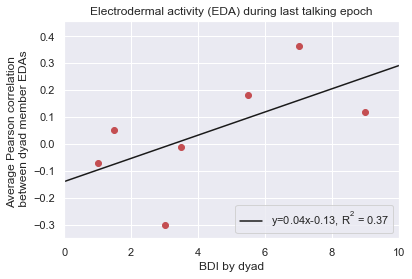

In [37]:
#BDI Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

x = [x for x in BDI if x >= 0]
y = [ps_talking['end'][i] for i in range(len(BDI)) if BDI[i] > 0]

model.fit(np.asarray(x).reshape(-1,1), y)
r_sq = model.score(np.asarray(x).reshape(-1,1), y)
intercept = model.intercept_
coef = model.coef_
print('coefficient of determination:', r_sq, 'intercept:', model.intercept_, 'coef:', model.coef_)

# Values for regression line
regx = np.asarray([-1,13])
regy = np.asarray([regx[0]*coef+intercept,regx[1]*coef+intercept])

# EDA vs BDI
plt.scatter(x, y, color = 'r')
reg = plt.plot(regx, regy, color = 'k')
plt.ylabel('Average Pearson correlation \n between dyad member EDAs')
plt.xlabel('BDI by dyad')
plt.legend(reg, ["y=0.04x-0.13, R$\mathregular{^{2}}$ = 0.37"], loc='lower right');
plt.title('Electrodermal activity (EDA) during last talking epoch')
plt.xlim([0,10])

coefficient of determination: 0.001129673255244934 intercept: 0.02307491863180941 coef: [0.0131315]


(0, 10)

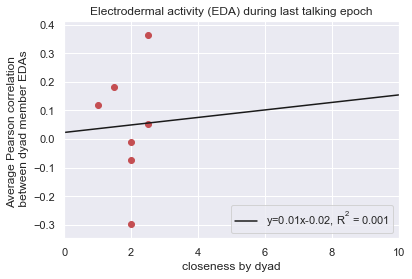

In [50]:
model = LinearRegression()

x = [x for x in closeness if x >= 0]
y = [ps_talking['end'][i] for i in range(len(closeness)) if closeness[i] > 0]

model.fit(np.asarray(x).reshape(-1,1), y)
r_sq = model.score(np.asarray(x).reshape(-1,1), y)
intercept = model.intercept_
coef = model.coef_
print('coefficient of determination:', r_sq, 'intercept:', model.intercept_, 'coef:', model.coef_)

# Values for regression line
regx = np.asarray([-1,13])
regy = np.asarray([regx[0]*coef+intercept,regx[1]*coef+intercept])

# EDA vs BDI
plt.scatter(x, y, color = 'r')
reg = plt.plot(regx, regy, color = 'k')
plt.ylabel('Average Pearson correlation \n between dyad member EDAs')
plt.xlabel('closeness by dyad')
plt.legend(reg, ["y=0.01x-0.02, R$\mathregular{^{2}}$ = 0.001"], loc='lower right');
plt.title('Electrodermal activity (EDA) during last talking epoch')
plt.xlim([0,10])

coefficient of determination: 0.18269613782448768 intercept: -0.06967338713063737 coef: [0.01836696]


(-1, 15)

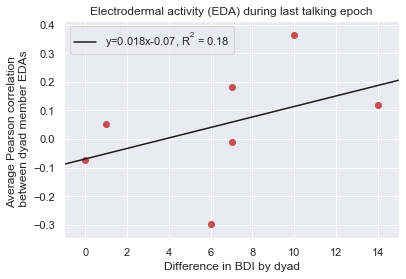

In [48]:
#diff BDI Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

x = [x for x in diff_BDI if x >= 0]
y = [ps_talking['end'][i] for i in range(len(diff_BDI)) if diff_BDI[i] >= 0]

model.fit(np.asarray(x).reshape(-1,1), y)
r_sq = model.score(np.asarray(x).reshape(-1,1), y)
intercept = model.intercept_
coef = model.coef_
print('coefficient of determination:', r_sq, 'intercept:', model.intercept_, 'coef:', model.coef_)
# Values for regression line
regx = np.asarray([-1,15])
regy = np.asarray([regx[0]*coef+intercept,regx[1]*coef+intercept])

# Values for regression line
regx = np.asarray([-1,15])
regy = np.asarray([regx[0]*coef+intercept,regx[1]*coef+intercept])

# EDA vs BDI
plt.scatter(diff_BDI, ps_talking['end'], color = 'r')
reg = plt.plot(regx, regy, color = 'k')
plt.ylabel('Average Pearson correlation \n between dyad member EDAs')
plt.xlabel('Difference in BDI by dyad')
plt.legend(reg, ["y=0.018x-0.07, R$\mathregular{^{2}}$ = 0.18"]);
plt.title('Electrodermal activity (EDA) during last talking epoch')
plt.xlim([-1,15])

coefficient of determination: 0.3830135717232491 intercept: -0.04298947633676508 coef: [0.09138943]


(-1, 5)

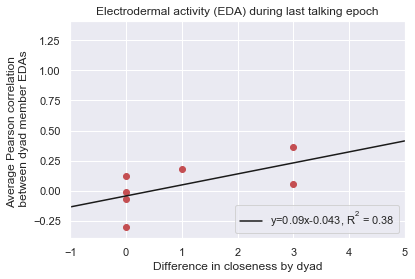

In [40]:
#diff closeness Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

x = [x for x in diff_closeness if x >= 0]
y = [ps_talking['end'][i] for i in range(len(diff_closeness)) if diff_closeness[i] >= 0]

model.fit(np.asarray(x).reshape(-1,1), y)
r_sq = model.score(np.asarray(x).reshape(-1,1), y)
intercept = model.intercept_
coef = model.coef_
print('coefficient of determination:', r_sq, 'intercept:', model.intercept_, 'coef:', model.coef_)

# Values for regression line
regx = np.asarray([-1,15])
regy = np.asarray([regx[0]*coef+intercept,regx[1]*coef+intercept])

# EDA vs BDI
plt.scatter(x, y, color = 'r')
reg = plt.plot(regx, regy, color = 'k')
plt.ylabel('Average Pearson correlation \n between dyad member EDAs')
plt.xlabel('Difference in closeness by dyad')
plt.legend(reg, ["y=0.09x-0.043, R$\mathregular{^{2}}$ = 0.38"], loc='lower right');
plt.title('Electrodermal activity (EDA) during last talking epoch')
plt.xlim([-1,5])